In [1]:
import parcels
import xmitgcm as xm
from datetime import timedelta, datetime
import os
import json

import random
import numpy as np
import time

import matplotlib.pyplot as plt
import pandas as pd

## Create velocity fields from MITgcm

In [ ]:
variables = {"U": "UVEL", "V": "VVEL", "W": "WVEL"}
dimensions = {
    "U": {
        "lon": "XG",
        "lat": "YG",
        "depth": "Z",
        "time": "time",
    },
    "V": {
        "lon": "XG",
        "lat": "YG",
        "depth": "Z",
        "time": "time",
    },
    "W": {
        "lon": "XG",
        "lat": "YG",
        "depth": "Z",
        "time": "time",
    },
}
fieldset = parcels.FieldSet.from_mitgcm(
    filenames=['/storage/alplakes_test/ARTFUL_project/01_2023-09-12/geneva_artful_01.nc'], 
    variables=variables, 
    dimensions=dimensions, 
    allow_time_extrapolation=False,
    mesh='flat') # mesh='flat' if longitudes and latitudes are given in meters, rather than degrees

## Create particle set

Here we create particles randomly seeded within a defined circle.

In [88]:
def RandomPointInCircle(R,xc,yc):
    r = R*random.random()
    theta = 2*np.pi*random.random()
    
    return xc+r*np.cos(theta),yc+r*np.sin(theta)

In [89]:
def RandomPointInRectangle(xmin, xmax, ymin, ymax):
    return xmin+(xmax-xmin)*random.random(), ymin+(ymax-ymin)*random.random()

In [95]:
n_part = 1000 # number of particles
depth_min = 4 # minimum release depth
depth_max = 10 # maximum release depth
(x_c,y_c) = (45000, 18000) # center of seeding point in MITgcm coordinates
r_seeding = 2000 # the radius around the center in m

zi_particles = np.array([-random.uniform(depth_min, depth_max) for i in range(n_part)])
xi_particles = x_c*np.ones(n_part)
yi_particles = y_c*np.ones(n_part)

init_time_particles = (np.datetime64('2021-09-03') - np.datetime64('2021-07-26'))/ np.timedelta64(1, 's') # seconds since ref_date
timei_particles = init_time_particles*np.ones(n_part)

for i in range(n_part):
    (xd,yd) = RandomPointInCircle(r_seeding,x_c,y_c)
    xi_particles[i] = xd
    yi_particles[i] = yd

In [96]:
pset = parcels.ParticleSet.from_list(
    fieldset=fieldset,  # the fields on which the particles are advected
    pclass=parcels.JITParticle,  # the type of particles (JITParticle or ScipyParticle)
    lon=xi_particles,  # a vector of release longitudes
    lat=yi_particles,  # a vector of release latitudes
    depth=zi_particles,
    time=timei_particles
)

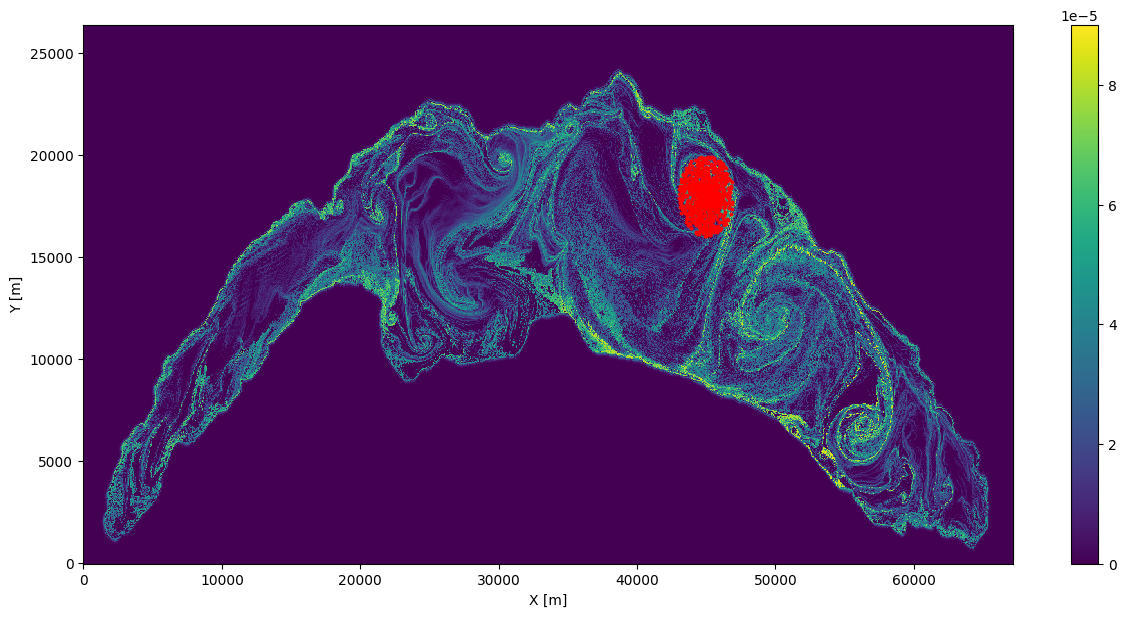

In [97]:
plt.figure(figsize=(15,7))
plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, df_ftle)
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.colorbar()

plt.scatter(pset.lon, pset.lat, s=3, c='r')
#plt.xlim(left=35000, right=50000)
#plt.ylim(bottom=15000)
plt.show()

## Set output parameters

In [99]:
output_file = pset.ParticleFile(
    name="eddy_analysis.zarr",  # the file name
    outputdt=timedelta(hours=1),  # the time step of the outputs
)

## Run simulation

In [100]:
start_clock = time.time()
pset.execute(
    parcels.AdvectionRK4,  # the kernel (which defines how particles move)
    runtime=timedelta(days=2),  # the total length of the run
    dt=timedelta(minutes=60),  # the timestep of the kernel
    output_file=output_file,
)
end_clock = time.time()
print(f'Done. Operation took {end_clock - start_clock}s.')

INFO: Output files are stored in eddy_analysis.zarr.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172800.0/172800.0 [05:01<00:00, 572.87it/s]
Done. Operation took 303.42479944229126s.
